In [1]:
%matplotlib inline
import parcels
from parcels import FieldSet, Field, AdvectionRK4_3D, AdvectionRK4, TimeConverter
from parcels import ErrorCode, Variable, FieldSamplingError, plotTrajectoriesFile
from parcels import JITParticle, ScipyParticle, ParticleFile, ParticleSet
from parcels import logger, XarrayDecodedFilter, GeographicPolar, Geographic
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt, animation
import cartopy
import datetime as dati
import netCDF4 as ntc
from operator import attrgetter
import time as tm
import os
from os import chdir, getcwd
import math
from math import sqrt, pi, cos
import warnings as wr

# OP Outputs

Let's just assume all the runs are done.

## Load a scenario

Let's get cracking!

In [3]:
# Choose
sc = 0
mo = 0
scens = np.array(["S0", "S1", "S2", "S3", "S4", "S5", "S6"])
mon_2 = np.array(["may", "jun", "jul", "aug", "sep", "oct"])
path = "E:\\OceanParcels"
ncname = path + "\\outputs\\atten_" + mon_2[mo] + "_" + scens[sc] + ".nc"
ncname

'E:\\OceanParcels\\outputs\\atten_may_S0.nc'

In [4]:
data_xr = xr.open_dataset(ncname).load()
data_xr.close()
data_xr
# warnings.simplefilter("ignore", category = RuntimeWarning) # if xarray is incessant

<xarray.Dataset>
Dimensions:     (trajectory: 6912, obs: 133)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 125 126 127 128 129 130 131 132
  * trajectory  (trajectory) int64 256 257 258 259 260 ... 7164 7165 7166 7167
Data variables:
    dist        (trajectory, obs) float32 0.0 0.0 nan nan ... nan nan nan nan
    lat         (trajectory, obs) float32 -43.12 -43.12 nan nan ... nan nan nan
    lon         (trajectory, obs) float32 147.6 147.6 nan nan ... nan nan nan
    res_time    (trajectory, obs) timedelta64[ns] 00:00:00 00:00:00 ... NaT NaT
    time        (trajectory, obs) timedelta64[ns] 00:00:00 00:00:00 ... NaT NaT
    z           (trajectory, obs) float32 4.8 4.8 nan nan ... nan nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.3.dev39

## Pset starting times

All the psets for attenuation have the same dt, so I can subset out the particles by their dt iteration.

In [35]:
pdt = np.arange(start = 0, dtype = '<m8[ns]', stop = dati.timedelta(days = 31), step = dati.timedelta(hours = 14))
ptime = data_xr['time'].values # (obs, times)

In [43]:
# Subet dimensions (using coordinate values) by release time
pset0 = parts[np.where(ptime[:,0] == pdt[0])]
pset1 = parts[np.where(ptime[:,0] == pdt[1])]

resi_pd = pd.DataFrame(resi_hr)
#resi_pd.to_csv(path + "\\outputs\\summary stats\\resi_hrs_" + mon_2[mo] + "_" + scens[sc] + ".csv", index = False)
dist_pd = pd.DataFrame(dist)
#dist_pd.to_csv(path + "\\outputs\\summary stats\\distance_" + mon_2[mo] + "_" + scens[sc] + ".csv", index = False)

array([ 0.4102192 ,  0.4102192 ,  0.7752558 ,  0.7752558 ,  1.386247  ,
        1.386247  ,  1.7872748 ,  1.7872748 ,  5.3400707 ,  5.3400707 ,
        2.3991375 ,  2.3991375 ,  1.8756301 ,  1.8756301 ,  1.2060944 ,
        1.2060944 ,  0.33154002,  0.33154002,  0.8486217 ,  0.8486217 ,
        1.4182836 ,  1.4182836 , 11.58784   , 11.58784   ,  7.043639  ,
        7.043639  ,  4.543928  ,  4.543928  ,  2.8418748 ,  2.8418748 ,
        1.9270474 ,  1.9270474 ,  0.47113794,  0.47113794,  0.7705894 ,
        0.7705894 ,  1.425476  ,  1.425476  ,  2.023262  ,  2.023262  ,
        3.9329655 ,  3.9329655 ,  6.601753  ,  6.601753  ,  2.5477223 ,
        2.5477223 ,  3.3189821 ,  3.3189821 ,  0.6532965 ,  0.6532965 ,
        0.93678546,  0.93678546,  1.3249384 ,  1.3249384 ,  2.0507975 ,
        2.0507975 ,  2.6141655 ,  2.6141655 ,  3.9240496 ,  3.9240496 ,
        4.2022333 ,  4.2022333 , 10.756924  , 10.756924  ,  4.9780483 ,
        4.9780483 ,  2.4060192 ,  2.4060192 ,  6.61072   ,  6.61

Did any particles get stuck? Do I need to remove?

In [52]:
data_1 = data_xr.isel(trajectory = pset0)
data_1

<xarray.Dataset>
Dimensions:     (trajectory: 128, obs: 133)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 125 126 127 128 129 130 131 132
  * trajectory  (trajectory) int64 512 513 514 515 516 ... 635 636 637 638 639
Data variables:
    dist        (trajectory, obs) float32 0.0 0.2614 0.4102 nan ... nan nan nan
    lat         (trajectory, obs) float32 -43.12 -43.12 -43.12 ... nan nan nan
    lon         (trajectory, obs) float32 147.6 147.6 147.6 nan ... nan nan nan
    res_time    (trajectory, obs) timedelta64[ns] 00:00:00 01:00:00 ... NaT NaT
    time        (trajectory, obs) timedelta64[ns] 1 days 04:00:00 ... NaT
    z           (trajectory, obs) float32 4.8 3.197 2.423 nan ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.3.dev39

In [72]:
# Basic stuff
x = data_1['lon'].values
x_d = x
y = data_1['lat'].values
z = data_1['z'].values
t_ns = data_1['time'].values # in nanoseconds
t_hr = t_ns.astype('timedelta64[h]')

# Sampled values
resi = data_1['res_time'].values
resi_hr = data_1['res_time'].values/1e9/60/60
dist = data_1['dist'].values

## Trajectory plots

These plots show slice of particles across times.

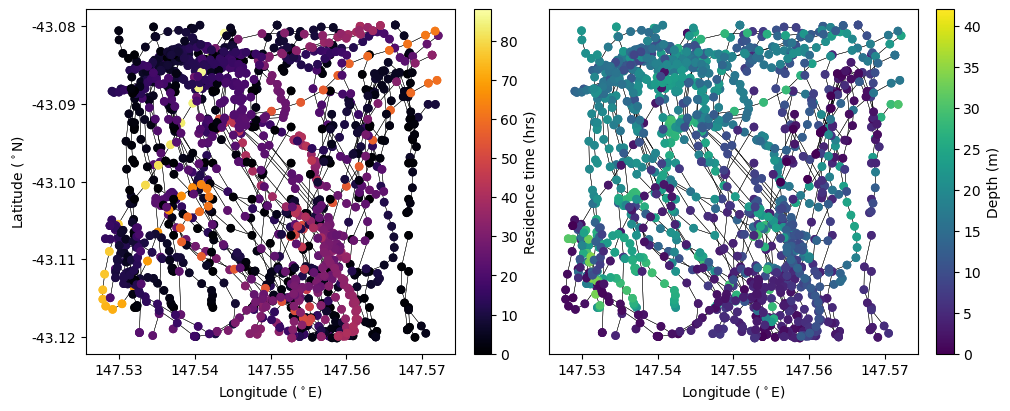

In [81]:
from matplotlib.ticker import FormatStrFormatter
fmt = lambda x, pos: '{:.2f}'.format(x, pos)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4), constrained_layout = True)

# Residence time
ax1.plot(x.transpose(), y.transpose(), c = 'k', zorder = 1, linewidth = 0.3)
res_plot = ax1.scatter(x, y, c = resi_hr, cmap = plt.cm.inferno, s = 3**3, edgecolor = None,
                       norm = matplotlib.colors.Normalize(vmin = 0, vmax = np.nanmax(resi_hr)))
# Depth plot
ax2.plot(x.transpose(), y.transpose(), c = 'k', zorder = 1, linewidth = 0.3)
dep_plot = ax2.scatter(x, y, c = z, cmap = plt.cm.viridis, s = 3**3, edgecolor = None,
                       norm = matplotlib.colors.Normalize(vmin = 0, vmax = 42))

# Label colourbars
plt.colorbar(res_plot, label = 'Residence time (hrs)')
plt.colorbar(dep_plot, label = 'Depth (m)')

# All the formatting
# All the formatting
yticks = ax1.get_ylim()
ax1.set_yticks((np.linspace(yticks[0]+0.002, yticks[1]-0.002, 5)))
xticks = ax1.get_xlim()
ax1.set_xticks((np.linspace(xticks[0]+0.005, xticks[1]-0.005, 5)))
ax2.set_xticks((np.linspace(xticks[0]+0.005, xticks[1]-0.005, 5)))
ax2.tick_params(left=False, labelleft=False)
ax1.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))
ax2.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))
ax1.set_ylabel("Latitude ($^\circ$N)")
ax1.set_xlabel("Longitude ($^\circ$E)")
ax2.set_xlabel("Longitude ($^\circ$E)")

plt.show()

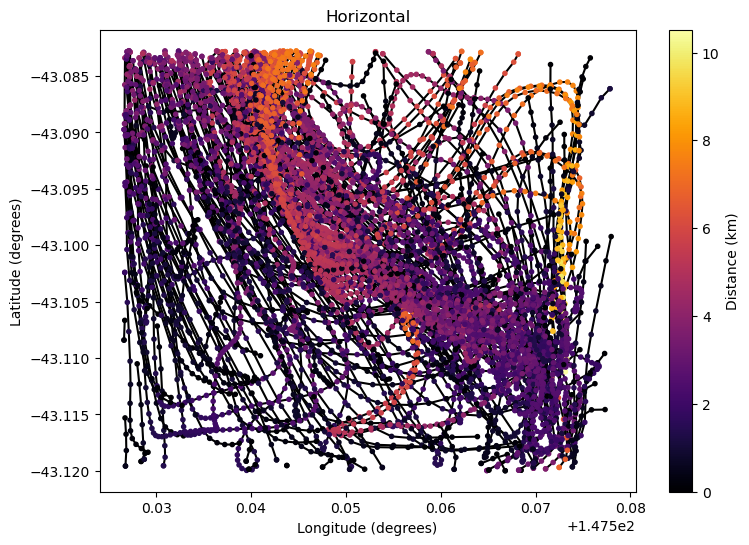

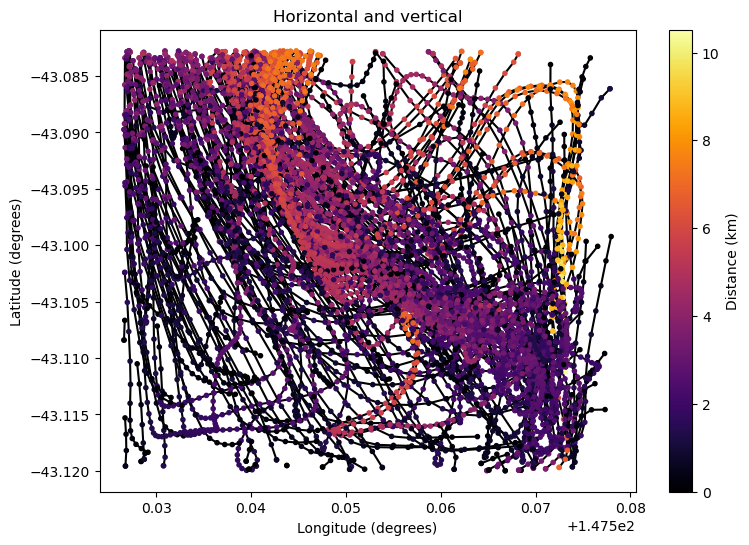

In [40]:
maxC = max(np.nanmax(dist_2D), np.nanmax(dist_3D))
minC = max(np.nanmin(dist_2D), np.nanmin(dist_3D))

fig1 = plt.figure(figsize = ((2.5+43/7),(42/7)))
ax1 = plt.axes() 
ax1.plot(x.transpose(), y.transpose(), c = 'k', zorder = 1)
dist_plot_1 = ax1.scatter(x, y, c = dist_2D, cmap = plt.cm.inferno, s = 3**2, #, edgecolor = 'k', zorder = 2,
                       norm = mpl.colors.Normalize(vmin = minC, vmax = maxC))
ax1.set_title("Horizontal")
plt.colorbar(dist_plot_1, label = 'Distance (km)')
ax1.set_ylabel('Latitude (degrees)')
ax1.set_xlabel('Longitude (degrees)')

fig2 = plt.figure(figsize = ((2.5+43/7),(42/7)))
ax2 = plt.axes() 
ax2.plot(x.transpose(), y.transpose(), c = 'k', zorder = 1)
dist_plot_2 = ax2.scatter(x, y, c = dist_3D, cmap = plt.cm.inferno, s = 3**2, #, edgecolor = 'k', zorder = 2,
                          norm = mpl.colors.Normalize(vmin = minC, vmax = maxC))
ax2.set_title("Horizontal and vertical")
plt.colorbar(dist_plot_2, label = 'Distance (km)')
ax2.set_ylabel('Latitude (degrees)')
ax2.set_xlabel('Longitude (degrees)')

plt.show()

## Non-sampling method of distance + residence time calculations

Does the 3D part really make a difference?

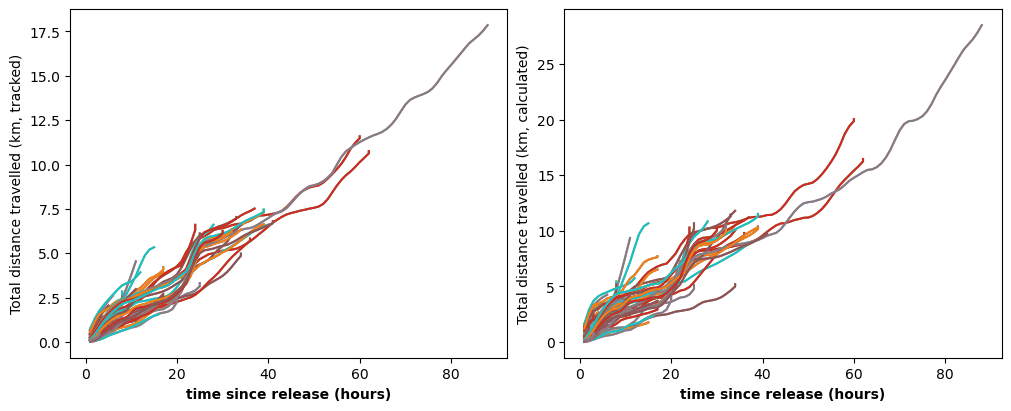

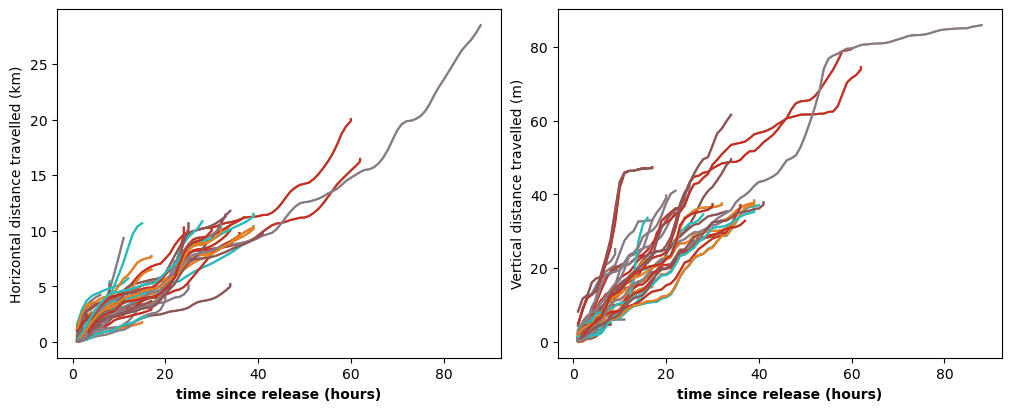

In [95]:
# Calculate total distance travelled
distance_calc = np.cumsum(np.sqrt(np.square(np.diff(x*np.cos(y*pi/180))*1.11e2) + # TOO COARSE - not spherical yet
                                  np.square(np.diff(y)*1.11e2) + 
                                  np.square(np.diff(z)/1e3)
                                 ), axis = 1)
distance_2D = np.cumsum(np.sqrt(np.square(np.diff(x*np.cos(y*pi/180))*1.11e2) + 
                                np.square(np.diff(y)*1.11e2)
                               ), axis = 1)
distance_dz = np.cumsum(np.sqrt(np.square(np.diff(z))
                               ), axis = 1)

# Time relative to particle, rather than run
t_rel = t_ns.transpose() - t_ns[:,0]
t_rel = t_rel.astype('timedelta64[h]')

# Plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
d_plot_dist = ax1.plot(t_rel[1:], dist[:,1:].transpose())
d_plot_calc = ax2.plot(t_rel[1:], distance_calc.transpose())

ax1.set_ylabel('Total distance travelled (km, tracked)')
ax2.set_ylabel('Total distance travelled (km, calculated)')
ax1.set_xlabel('time since release (hours)', weight = 'bold')
ax2.set_xlabel('time since release (hours)', weight = 'bold')

plt.show()

# Plot2
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
d_plot_2D = ax1.plot(t_rel[1:], distance_2D.transpose())
d_plot_dz = ax2.plot(t_rel[1:], distance_dz.transpose())

ax1.set_ylabel('Horizontal distance travelled (km)')
ax2.set_ylabel('Vertical distance travelled (m)')
ax1.set_xlabel('time since release (hours)', weight = 'bold')
ax2.set_xlabel('time since release (hours)', weight = 'bold')

plt.show()

## Residence time

In [21]:
np.set_printoptions(linewidth=160)

t_rel = t_ns.transpose() - t_ns[:,0]
t_rel = t_rel.astype('timedelta64[m]')
res_time = np.nanmax(t_rel, axis = 0)
res_time = res_time[~np.isnat(res_time)]

print(np.shape(res_time))

(192,)


Probably going to need to look at the "working with large outputs" tutorial, here: https://docs.oceanparcels.org/en/latest/examples/tutorial_output.html

In [35]:
np.shape((dist.transpose()))

(211, 1792)